# A/B testing in Python 

I'll use a <a href='https://www.kaggle.com/zhangluyuan/ab-testing?select=ab_data.csv'>dataset from Kaggle</a> which contains the results of an A/B test on what seems to be 2 different designs of a website page (old_page vs. new_page) and analyze if they show statistically sigfinicant conversion rates.  

The potential scenario:
> Let's imagine you work on the product team at a medium-sized **online e-commerce business**. The UX designer worked really hard on a new version of the product page, with the hope that it will lead to a higher conversion rate. The product manager (PM) told you that the **current conversion rate** is about **13%** on average throughout the year, and that the team would be happy with an **increase of 2%**, meaning that the new design will be considered a success if it raises the conversion rate to 15%.

Here are the 5 steps: 
1. [Designing experiment](#1.-Designing-our-experiment)
2. [Collecting and preparing the data](#2.-Collecting-and-preparing-the-data)
3. [Visualising the results](#3.-Visualising-the-results)
4. [Testing the hypothesis](#4.-Testing-the-hypothesis)
5. [Conclusions](#5.-Drawing-conclusions)

### `ab_data.csv`

There are **294478 rows** in the DataFrame, each representing a user session, as well as **5 columns** :
* `user_id` - The user ID of each session
* `timestamp` - Timestamp for the session
* `group` - Which group the user was assigned to for that session {`control`, `treatment`}
* `landing_page` - Which design each user saw on that session {`old_page`, `new_page`}
* `converted` - Whether the session ended in a conversion or not (binary, `0`=not converted, `1`=converted)

***
## 1. Designing experiment

### Formulating a hypothesis

Given we don't know if the new design will perform better or worse (or the same?) as the current design, I'll choose a <a href="https://en.wikipedia.org/wiki/One-_and_two-tailed_tests">**two-tailed test**</a> since I have no reason to know a priori whether the discrepancy between the results of A and B will be in favor of A or B.:

$$H_0: p = p_0$$
$$H_a: p \ne p_0$$

where $p$ and $p_0$ stand for the conversion rate of the new and old design, respectively. I'll also set a **confidence level of 95%**:

$$\alpha = 0.05$$



### Choosing the variables

For our test we'll need **two groups**:
* A `control` group - They'll be shown the old design
* A `treatment` (or experimental) group - They'll be shown the new design

This will be our *Independent Variable*. 

For *Dependent Variable*, I am interested in capturing the `conversion rate`, which is a discrete metric (also called binomial metrics):
* `0` - The user did not buy the product during this user session
* `1` - The user bought the product during this user session

*So how many people should I have in each group?*

The sample size I need is estimated through something called <a href="https://research.usu.edu//irb/wp-content/uploads/sites/12/2015/08/A_Researchers_Guide_to_Power_Analysis_USU.pdf">*Power analysis*</a>, and it depends on a few factors:
* **Power of the test** ($1 - \beta$) - This represents the probability of finding a statistical difference between the groups in our test when a difference is actually present. This is usually set at 0.8 as a convention (here's more info on <a href="https://en.wikipedia.org/wiki/Power_of_a_test">statistical power</a>, if you are curious)
* **Alpha value** ($\alpha$) - The critical value we set earlier to 0.05
* **Effect size** - How big of a difference we expect there to be between the conversion rates

Since our team would be happy with a difference of 2%, we can use 13% and 15% to calculate the effect size we expect. 

In [41]:
# Packages imports
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.stats.api as sms
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil
import statsmodels.api as sm

%matplotlib inline

# Some plot styling preferences
plt.style.use('seaborn-whitegrid')
font = {'family' : 'Helvetica',
        'weight' : 'bold',
        'size'   : 14}

mpl.rc('font', **font)

/var/folders/lc/5ptj5wrd1bd0p_gvjmns5fsr0000gn/T/ipykernel_73653/1716625722.py:15: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


In [42]:
effect_size = sms.proportion_effectsize(0.13, 0.15)    # Calculating effect size based on our expected rates

required_n = sms.NormalIndPower().solve_power(
    effect_size, 
    power=0.8, 
    alpha=0.05, 
    ratio=1
    )                                                  # Calculating sample size needed

required_n = ceil(required_n)                          # Rounding up to next whole number                          

print(required_n)

4720


I need **at least 4720 observations** for each group. 

***
## 2. Collecting and preparing the data

1. Use EDA to explore the dataset and clean the data as needed
4. Randomly sample `n=4720` rows from the DataFrame for each group 

In [43]:
df = pd.read_csv('ab_data.csv')

df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [44]:
df.isna().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

In [45]:
(df['converted']==1).mean()

0.11965919355605512

In [46]:
(df.query('group=="control"')['converted']==1).mean()

0.12039917935897611

In [47]:
(df.query('group=="treatment"')['converted']==1).mean()

0.11891957956489856

The new page isn't doing too good on the conversion improvement. In fact, it's doing slightly worse than the control group.

In [48]:
pd.crosstab(df['group'], df['landing_page'])

landing_page,new_page,old_page
group,,
control,1928,145274
treatment,145311,1965


In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [50]:
df['user_id'].nunique()

290584

286690 unique users and 294478 entries, so there is discrepency. 

In [51]:
session_counts = df['user_id'].value_counts(ascending=False)
repeated_users = session_counts[session_counts > 1].count()

print(f'There are {repeated_users} users that appear multiple times in the dataset')

users_to_drop = session_counts[session_counts > 1].index

df = df[~df['user_id'].isin(users_to_drop)]
print(f'The updated dataset now has {df.shape[0]} entries')

There are 3894 users that appear multiple times in the dataset
The updated dataset now has 286690 entries


### Sampling

In [52]:
control_sample = df[df['group'] == 'control'].sample(n=required_n, random_state=22)
control_sample

,user_id,timestamp,group,landing_page,converted
186628,763854,2017-01-21 03:43:17.188315,control,old_page,0
57904,690555,2017-01-18 06:38:13.079449,control,old_page,0
13276,861520,2017-01-06 21:13:40.044766,control,old_page,0
228415,630778,2017-01-05 16:42:36.995204,control,old_page,0
96065,656634,2017-01-04 15:31:21.676130,control,old_page,0
...,...,...,...,...,...
94034,646677,2017-01-17 15:34:00.011127,control,old_page,0
77635,895315,2017-01-07 02:41:17.321930,control,old_page,0
63216,648194,2017-01-16 22:44:54.889419,control,old_page,0
169629,872383,2017-01-12 23:47:30.689899,control,old_page,0


In [53]:
treatment_sample = df[df['group'] == 'treatment'].sample(n=required_n, random_state=22)
treatment_sample

,user_id,timestamp,group,landing_page,converted
259346,860447,2017-01-11 21:20:47.193292,treatment,new_page,0
237647,845654,2017-01-06 21:49:33.725054,treatment,new_page,0
73088,833106,2017-01-11 21:56:24.637002,treatment,new_page,0
121106,665687,2017-01-08 04:17:45.135586,treatment,new_page,0
78032,658409,2017-01-22 13:18:58.765132,treatment,new_page,0
...,...,...,...,...,...
46153,908512,2017-01-14 22:02:29.922674,treatment,new_page,0
235886,873211,2017-01-05 00:57:16.167151,treatment,new_page,0
268794,631276,2017-01-20 18:56:58.167809,treatment,new_page,0
190461,662301,2017-01-03 08:10:57.768806,treatment,new_page,0


In [54]:
ab_test_df = pd.concat([control_sample, treatment_sample], axis=0)
ab_test_df.reset_index(drop=True, inplace=True)

In [55]:
ab_test_df

,user_id,timestamp,group,landing_page,converted
0,763854,2017-01-21 03:43:17.188315,control,old_page,0
1,690555,2017-01-18 06:38:13.079449,control,old_page,0
2,861520,2017-01-06 21:13:40.044766,control,old_page,0
3,630778,2017-01-05 16:42:36.995204,control,old_page,0
4,656634,2017-01-04 15:31:21.676130,control,old_page,0
...,...,...,...,...,...
9435,908512,2017-01-14 22:02:29.922674,treatment,new_page,0
9436,873211,2017-01-05 00:57:16.167151,treatment,new_page,0
9437,631276,2017-01-20 18:56:58.167809,treatment,new_page,0
9438,662301,2017-01-03 08:10:57.768806,treatment,new_page,0


In [56]:
ab_test_df['group'].value_counts()

control      4720
treatment    4720
Name: group, dtype: int64

***
## 3. Visualizing the results

In [57]:
conversion_rates = ab_test_df.groupby('group')['converted']

std_p = lambda x: np.std(x, ddof=0)              # Std. deviation of the proportion
se_p = lambda x: stats.sem(x, ddof=0)            # Std. error of the proportion (std / sqrt(n))

conversion_rates = conversion_rates.agg([np.mean, std_p, se_p])
conversion_rates.columns = ['conversion_rate', 'std_deviation', 'std_error']


conversion_rates.style.format('{:.3f}')

,conversion_rate,std_deviation,std_error
group,,,
control,0.123,0.329,0.005
treatment,0.126,0.331,0.005


The control group shows us 12.3% conversion rate and the treatment group 12.6% conversion rate, which are very close.

/var/folders/lc/5ptj5wrd1bd0p_gvjmns5fsr0000gn/T/ipykernel_73653/1535957482.py:1: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', False)` for the same effect.

  sns.barplot(x=ab_test_df['group'], y=ab_test_df['converted'], ci=False)


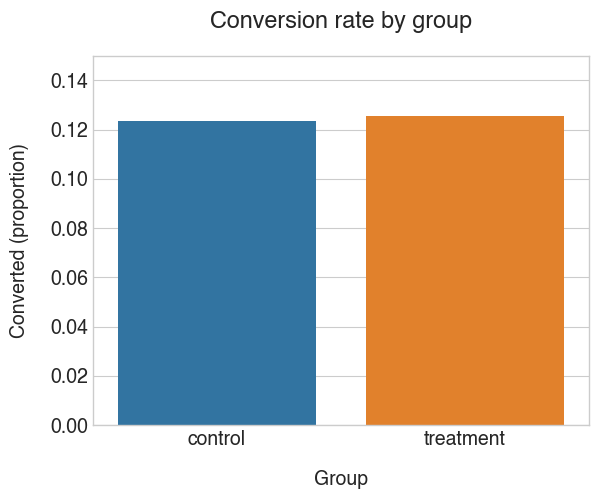

In [58]:
sns.barplot(x=ab_test_df['group'], y=ab_test_df['converted'], ci=False)

plt.ylim(0, 0.15)
plt.title('Conversion rate by group', pad=20)
plt.xlabel('Group', labelpad=15)
plt.ylabel('Converted (proportion)', labelpad=15);

***
## 4. Testing Hypothesis 


### Z-test and confidence intervals

In [59]:
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

In [60]:
control_conversion = ab_test_df.query('group == "control"')['converted']
treatment_conversion = ab_test_df.query('group == "treatment"')['converted']

In [61]:
nobs = [control_conversion.count(), treatment_conversion.count()]
successes = [control_conversion.sum(), treatment_conversion.sum()]

z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

print(f'z statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'95% Confidence interval for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'95% Confidence interval for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

z statistic: -0.34
p-value: 0.732
95% Confidence interval for control group: [0.114, 0.133]
95% Confidence interval for treatment group: [0.116, 0.135]


### Regression analysis 

In [62]:
ab_test_df['intercept']=1

ab_test_df['group_dummy_variable']=pd.get_dummies(ab_test_df['group'])['treatment']

In [63]:
ab_test_df

,user_id,timestamp,group,landing_page,converted,intercept,group_dummy_variable
0,763854,2017-01-21 03:43:17.188315,control,old_page,0,1,0
1,690555,2017-01-18 06:38:13.079449,control,old_page,0,1,0
2,861520,2017-01-06 21:13:40.044766,control,old_page,0,1,0
3,630778,2017-01-05 16:42:36.995204,control,old_page,0,1,0
4,656634,2017-01-04 15:31:21.676130,control,old_page,0,1,0
...,...,...,...,...,...,...,...
9435,908512,2017-01-14 22:02:29.922674,treatment,new_page,0,1,1
9436,873211,2017-01-05 00:57:16.167151,treatment,new_page,0,1,1
9437,631276,2017-01-20 18:56:58.167809,treatment,new_page,0,1,1
9438,662301,2017-01-03 08:10:57.768806,treatment,new_page,0,1,1


In [64]:
lm = sm.Logit(ab_test_df['converted'], ab_test_df[['intercept', 'group_dummy_variable']])
results=lm.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.375732
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:                 9440
Model:                          Logit   Df Residuals:                     9438
Method:                           MLE   Df Model:                            1
Date:                Fri, 07 Jul 2023   Pseudo R-squ.:               1.658e-05
Time:                        12:31:25   Log-Likelihood:                -3546.9
converged:                       True   LL-Null:                       -3547.0
Covariance Type:            nonrobust   LLR p-value:                    0.7316
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
intercept               -1.9615      0.044    -44.307      0.000      -2.048      -1.875
group_dummy_variable     0.0214      0.062      0.343      0.732      -0.101       0.144
========================================================================================
"""

The estimated coefficient for the 'group_dummy_variable' is 0.0214. This means that for each unit increase in the "group_dummy_variable" (which represents the treatment group in this case), the log-odds of the outcome variable (converted) increase by 0.0214. Since the coefficient is positive, it suggests that being in the treatment group (as indicated by the "group_dummy_variable") is associated with a higher likelihood of the outcome variable (converted) occurring. However, it is not statistically significant as the associated p-value is 0.732 (> 0.05).

***
## 5. Conlusions

Although the treatment group initially appeared to have a slightly higher conversion rate, the p-value being greater than 0.05 indicates that we cannot accept the alternative hypothesis. Furthermore, the confidence intervals encompass our baseline conversion rate of 12%.

Hence, it can be concluded that the new version of the site does not significantly increase conversion. Based on the results of the A/B test, it is not advisable for the company to implement the new site version.